In [1]:
#| default_exp init

In [2]:
#|export
import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
import sys,gc,traceback
import fastcore.all as fc
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *

In [3]:

from fastcore.test import test_close

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)

import logging
logging.disable(logging.WARNING)

set_seed(42)

In [4]:

xl,yl = 'image','label'
name = "fashion_mnist"
dsd = load_dataset(name)

@inplace
def transformi(b): b[xl] = [TF.to_tensor(o) for o in b[xl]]

bs = 1024
tds = dsd.with_transform(transformi)

dls = DataLoaders.from_dd(tds, bs, num_workers=4)
dt = dls.train
xb,yb = next(iter(dt))
xb.shape,yb[:10]

(torch.Size([1024, 1, 28, 28]), tensor([5, 7, 4, 7, 3, 8, 9, 5, 3, 1]))

In [5]:

from fastcore.test import test_close

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)

import logging
logging.disable(logging.WARNING)

set_seed(42)

In [6]:

def get_model():
    return nn.Sequential(conv(1 ,8), conv(8 ,16), conv(16,32), conv(32,64),
                         conv(64,10, act=False), nn.Flatten()).to(def_device)

/home/chung/miniconda3/lib/python3.11/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1708025842427/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


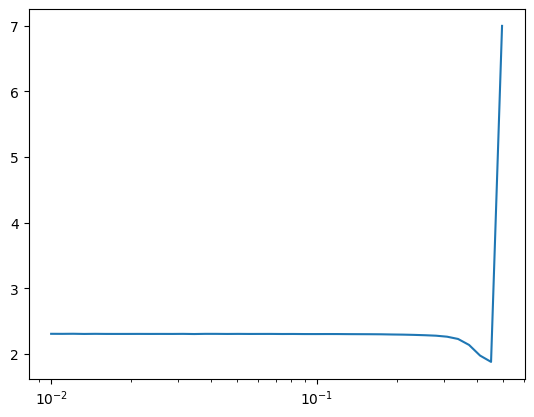

In [7]:
MomentumLearner(get_model(), dls, F.cross_entropy, cbs=[DeviceCB()]).lr_find(gamma=1.1, start_lr=1e-2)

In [8]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
astats = ActivationStats(fc.risinstance(nn.ReLU))
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), astats]
learn = MomentumLearner(get_model(), dls, F.cross_entropy, lr=0.2, cbs=cbs)

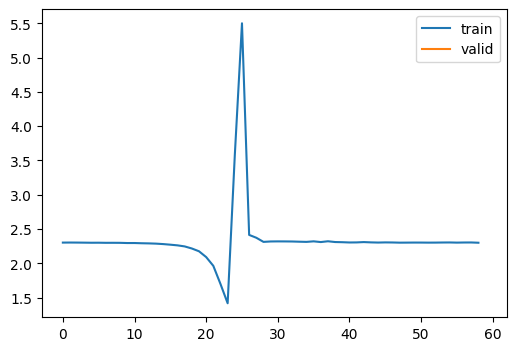

In [9]:
learn.fit(1)

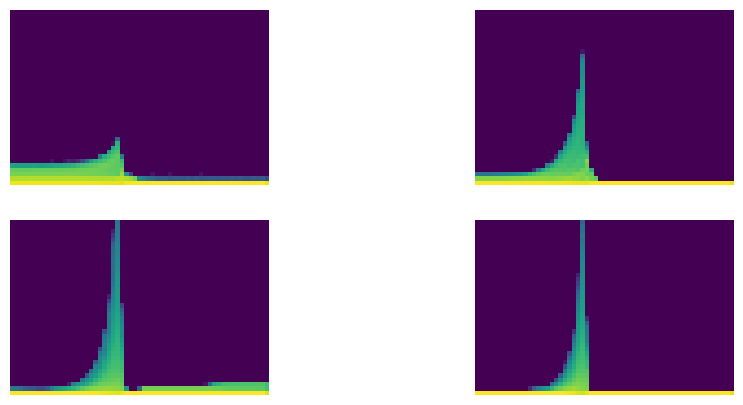

In [10]:
astats.color_dim()

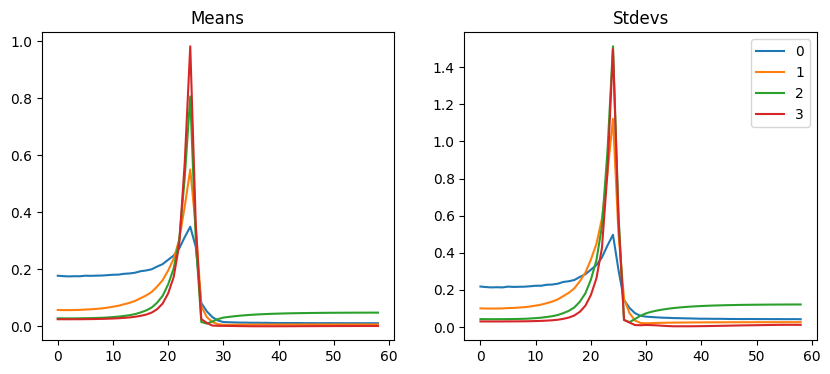

In [11]:
astats.plot_stats()

In [12]:
#| export 
def clean_ipython_hist():
    # code in this function mainly copied from IPython source
    if not 'get_ipython' in globals(): return
    ip = get_ipython()
    user_ns = ip.user_ns
    ip.displayhook.flush()
    pc = ip.displayhook.prompt_count + 1
    for n in range(1, pc): user_ns.pop('_i' + repr(n), None)
    user_ns.update(dict(_i='', _ii='', _iii=''))
    hm = ip.history_manager
    hm.input_hist_parsed[:] = [''] * pc
    hm.input_hist_raw[:] = [''] * pc
    hm._i = hm._ii = hm._iii = hm._i00 = ''

In [13]:
#| export
def clean_tb():
    # h/t Prior Czapla
    if hasattr(sys, 'last_trackback'):
        traceback.clear_frames(sys.last_traceback)
        delattr(sys, 'last_traceback')
    if hasattr(sys, 'last_type'): delattr(sys, 'last_type')
    if hasattr(sys, 'last_value'): delattr(sys, 'last_value')

In [14]:
#| export
def clean_mem():
    clean_tb()
    clean_ipython_hist()
    gc.collect()
    torch.cuda.empty_cache()

### Glorot/Xavier init

In [15]:
x = torch.randn(200, 100)
for i in range(50): x = x @ torch.randn(100,100)
x[0:5,0:5]

tensor([[nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan]])

The result is nan's everywhere. So maybe the scale or our matrix was too big, and we need to have smaller weights? But if we use too small weights, we will have the opposite problem--the scale of our activations will go from 1 to 0.1, and after 50 layers we'll be left zeros everywhere:

In [16]:
x = torch.randn(200, 100)
for i in range(50): x = x @ (torch.randn(100,100) * 0.01)
x[0:5,0:5]

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])

So we have to scale our weight matrices exactly right so the standard deviation of our activations stays at 1.  We can compute the exact value to use mathematically, as illustrated by Xavier Glorot and Yoshua Bengio in "Understanding the Difficulty of Training Deep FeedForward Neural Networks". The right scale for a given layer is $1/\sqrt{n_{in}}$ where ${n_{in}}$ represents the number of inputs. 

In [17]:
x = torch.randn(200,100)
for i in range(50): x = x @ (torch.randn(100, 100) * 0.1)
x[0:5,0:5]

tensor([[-0.24, -0.20,  1.21, -0.63, -0.50],
        [-0.05, -0.15, -0.06, -0.11, -0.13],
        [-1.22, -0.06, -1.84,  0.24, -0.29],
        [-1.55, -0.18, -0.65,  0.00, -0.24],
        [ 0.34, -0.11,  1.33, -0.49, -0.45]])

### Background

### Variance and standard deviation

Variance is the average of how far away each data point is from the mean. E.g:

In [18]:
t = torch.tensor([1.,2.,4.,18])

In [19]:
m = t.mean(); m

tensor(6.25)

In [20]:
(t-m).mean()

tensor(0.)

Oops. We can't do that. Because by definition the positives and negatives cancel out. So we can fix that in one of (at least) two ways:

In [21]:
(t-m).pow(2).mean()

tensor(47.19)

In [22]:
(t-m).abs().mean()

tensor(5.88)

But the first of these is now a totally different scale, since we squared. So let's undo that at the end.

In [23]:
(t-m).pow(2).mean().sqrt()

tensor(6.87)

In [24]:
(t-m).pow(2).mean(), (t*t).mean()-(m*m)

(tensor(47.19), tensor(47.19))

In [25]:
t

tensor([ 1.,  2.,  4., 18.])

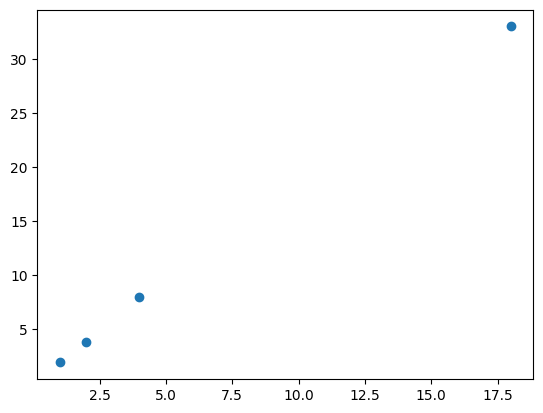

In [26]:
# `u` is twice `t`, plus a bit of randomness
u = t*2
u *= torch.randn_like(t)/10 + 0.95

plt.scatter(t, u);

In [27]:
prod = ((t-t.mean())*(u-u.mean())); prod

tensor([ 51.29,  33.42,   8.42, 251.15])

In [28]:
prod.mean()

tensor(86.07)

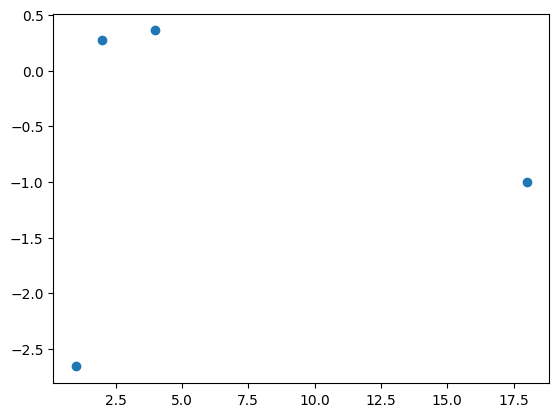

In [29]:
v = torch.randn_like(t)
plt.scatter(t, v);

In [30]:
((t-t.mean())*(v-v.mean())).mean()

tensor(0.05)

In [31]:
cov = (t*v).mean() - t.mean()*v.mean(); cov

tensor(0.05)

In [32]:
cov / (t.std() * v.std())

tensor(0.00)

In [33]:
x = torch.randn(100)
x.mean(), x.std()

(tensor(0.01), tensor(0.88))

In [34]:
mean, sqr = 0., 0.
for i in range(100):
    x = torch.randn(100)
    a = torch.randn(512, 100)
    y = a @ x
    mean += y.mean().item()
    sqr  += y.pow(2).mean().item()
mean/100, sqr/100

(0.11528873899951578, 99.97023384094238)

In [35]:
mean, sqr = 0.,0.
for i in range(10000):
    x = torch.randn(1)
    a = torch.randn(1)
    y = a*x
    mean += y.item()
    sqr  += y.pow(2).item()
mean/10000, sqr/10000

(-0.019238901931394867, 0.9925146215551511)

### Kaiming/He init

### Background

In [36]:
x = torch.randn(200, 100)
y = torch.randn(200)

In [37]:
from math import sqrt

In [38]:
w1 = torch.randn(100, 50) / sqrt(100)
b1 = torch.zeros(50)
w2 = torch.randn(50,1) / sqrt(50)
b2 = torch.zeros(1)


In [39]:
def lin(x, w, b): return x @ w + b

In [40]:
l1 = lin(x, w1, b1)
l1.mean(), l1.std()

(tensor(-0.01), tensor(1.00))

In [41]:
def relu(x): return x.clamp_min(0.)

In [42]:
l2 = relu(l1)
l2.mean(), l2.std()

(tensor(0.39), tensor(0.58))

In [43]:
x = torch.rand(200, 100)
for i in range(50): x = relu(x @ (torch.randn(100,100) * 0.01))
x[0:5,0:5]

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])

In "Delving Deep into Rectifiers: Surpassing Human-Level Performance" Kaiming He et al. show that we should use the following scale instead: $\sqrt{2/n_{in}}$ where $n_{in}$ is the number of inputs of our model.

In [44]:
x = torch.randn(200, 100)
for i in range(50): x = relu(x @ (torch.randn(100,100) * sqrt(2/100)))
x[0:5,0:5]

tensor([[0.58, 0.00, 3.08, 0.00, 0.05],
        [0.55, 0.00, 3.03, 0.00, 0.00],
        [1.22, 0.00, 6.29, 0.00, 0.04],
        [0.47, 0.00, 2.34, 0.00, 0.00],
        [0.56, 0.00, 3.06, 0.00, 0.00]])

### Applying an init function

In [45]:
model = get_model()
model.apply(lambda m: print(type(m).__name__));

Conv2d
ReLU
Sequential
Conv2d
ReLU
Sequential
Conv2d
ReLU
Sequential
Conv2d
ReLU
Sequential
Conv2d
Flatten
Sequential


In [46]:
def init_weights(m):
    if isinstance(m, (nn.Conv1d,nn.Conv2d,nn.Conv3d,nn.Linear)): init.kaiming_normal_(m.weight)

In [47]:
model.apply(init_weights);

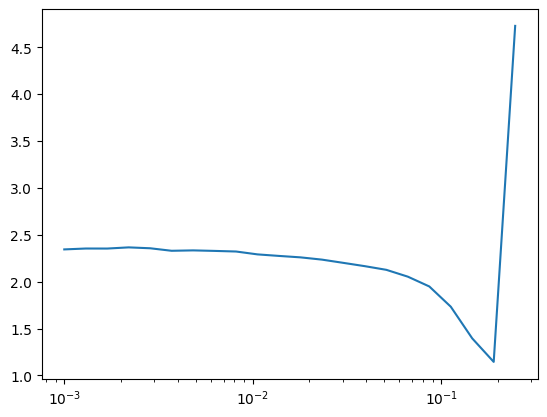

In [48]:
lrf_cbs = [DeviceCB(), ProgressCB(), LRFinderCB()]
learn = MomentumLearner(model, dls, F.cross_entropy, lr=1e-3, cbs=lrf_cbs)
learn.fit(1)

accuracy,loss,epoch,train
0.261,2.223,0,train
0.252,1.973,0,eval
0.108,2.330,1,train
0.104,2.302,1,eval
0.127,2.290,2,train
0.100,2.304,2,eval


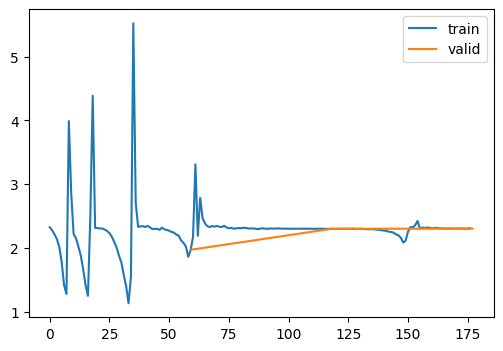

In [50]:
set_seed(42)
learn = MomentumLearner(get_model().apply(init_weights), dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(3)

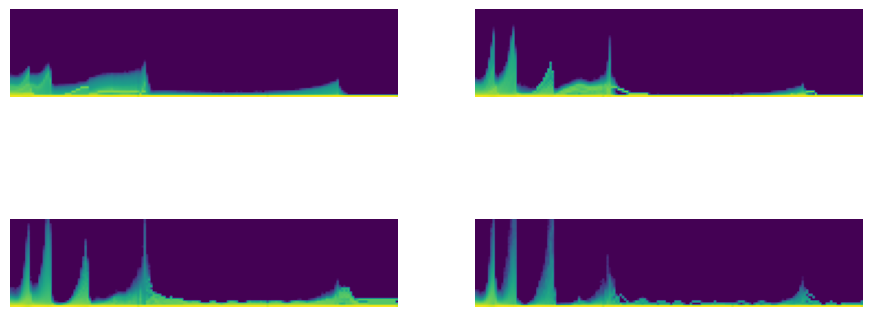

In [51]:
astats.color_dim()

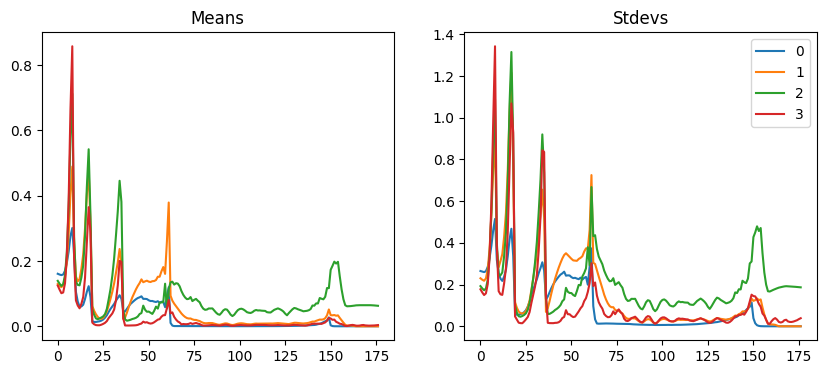

In [52]:
astats.plot_stats()

In [53]:
xmean,xstd = xb.mean(),xb.std()
xmean,xstd

(tensor(0.29), tensor(0.35))

In [54]:
#export
class BatchTransformCB(Callback):
    def __init__(self, tfm): self.tfm = tfm
    def before_batch(self, learn): learn.batch = self.tfm(learn.batch)

In [55]:
def _norm(b): return (b[0]-xmean)/xstd,b[1]
norm = BatchTransformCB(_norm)

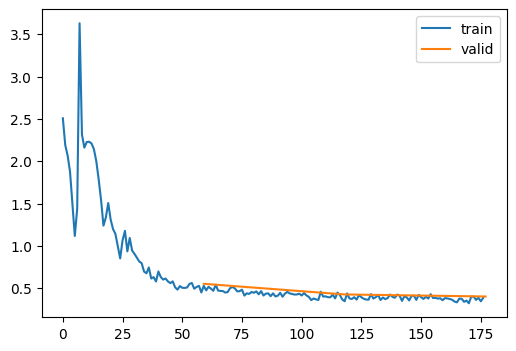

In [56]:
set_seed(42)
learn = MomentumLearner(get_model().apply(init_weights), dls, F.cross_entropy, lr=0.2, cbs=cbs+[norm])
learn.fit(3)

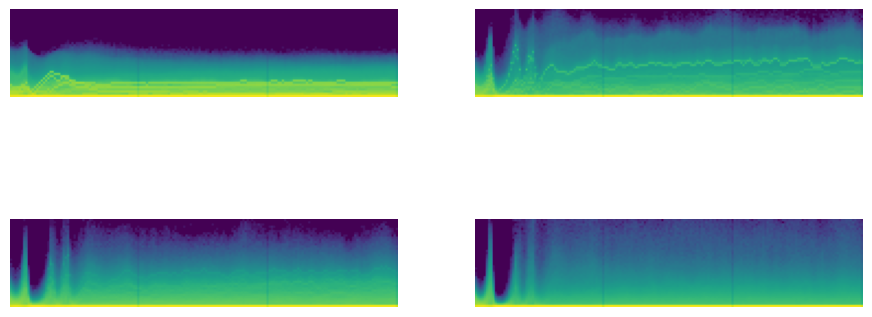

In [57]:
astats.color_dim()

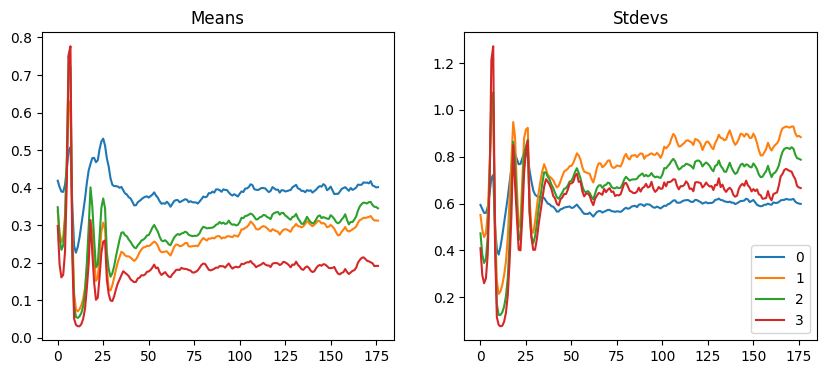

In [58]:
astats.plot_stats()

In [59]:
@inplace
def transformi(b): b[xl] = [(TF.to_tensor(o)-xmean)/xstd for o in b[xl]]
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=4)
xb,yb = next(iter(dls.train))

In [60]:
xb.mean(),xb.std()

(tensor(0.01), tensor(1.00))

### General ReLU

In [61]:
#| export
class GeneralRelu(nn.Module):
    def __init__(self, leak=None, sub=None, maxv=None):
        super().__init__()
        self.leak,self.sub,self.maxv = leak,sub,maxv

    def forward(self, x):
        x = F.leaky_relu(x,self.leak) if self.leak is not None else F.relu(x)
        if self.sub is not None: x -= self.sub
        if self.maxv is not None: x.clamp_max(self.maxv)
        return x

In [62]:
def plot_func(f, start=-5., end=5., steps=100):
    x = torch.linspace(start, end, steps)
    plt.plot(x, f(x))
    plt.grid(True, which='both', ls='--')
    plt.axhline(y=0, color='k', linewidth=0.7)
    plt.axvline(x=0, color='k', linewidth=0.7)


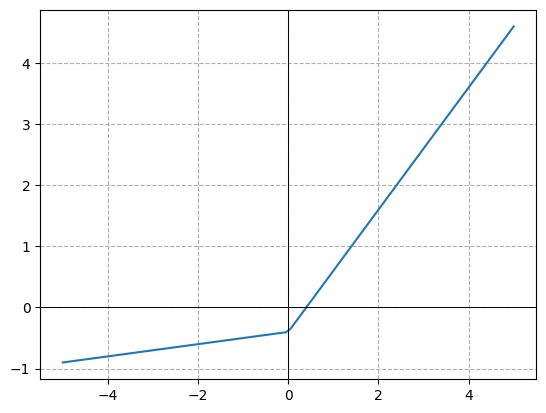

In [63]:
plot_func(GeneralRelu(leak=0.1, sub=0.4))

In [64]:
def conv(ni, nf, ks=3, stride=2, act=nn.ReLU):
    res = nn.Conv2d(ni, nf, stride=stride, kernel_size=ks, padding=ks//2)
    if act: res = nn.Sequential(res, act())
    return res

In [65]:
def get_model(act=nn.ReLU, nfs=None):
    if nfs is None: nfs = [1,8,16,32,64]
    layers = [conv(nfs[i], nfs[i+1], act=act) for i in range(len(nfs)-1)]
    return nn.Sequential(*layers, conv(nfs[-1], 10, act=None), nn.Flatten()).to(def_device)

In [66]:
#|export
def init_weights(m, leaky=0.):
    if isinstance(m, (nn.Conv1d, nn.Conv2d,nn.Conv3d,nn.Linear)): init.kaiming_normal_(m.weight, a=leaky)

In [67]:
act_gr = partial(GeneralRelu, leak=0.1, sub=0.4)
astats = ActivationStats(fc.risinstance(GeneralRelu))
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), astats]
iw = partial(init_weights, leaky=0.1)

In [68]:
model = get_model(act_gr).apply(iw)

accuracy,loss,epoch,train
0.778,0.615,0,train
0.846,0.427,0,eval
0.869,0.361,1,train
0.861,0.374,1,eval
0.881,0.324,2,train
0.867,0.361,2,eval


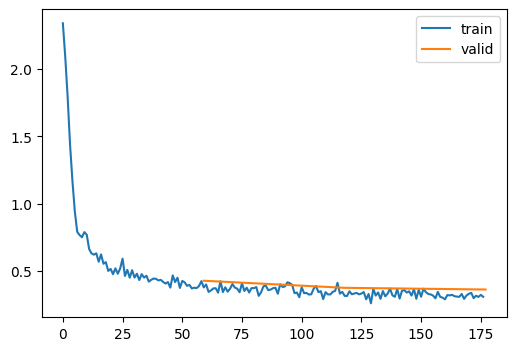

In [69]:
set_seed(42)
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(3)

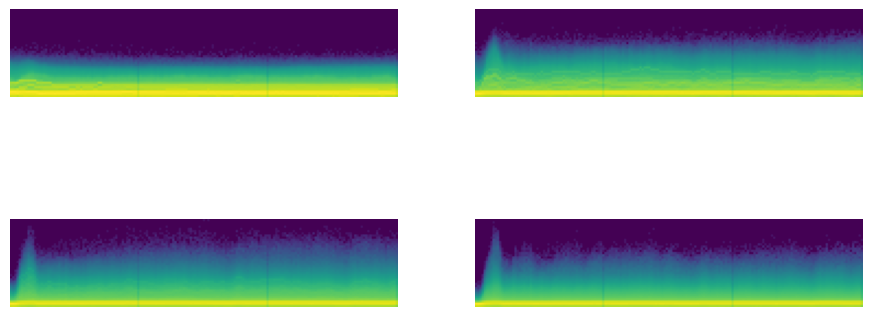

In [70]:
astats.color_dim()

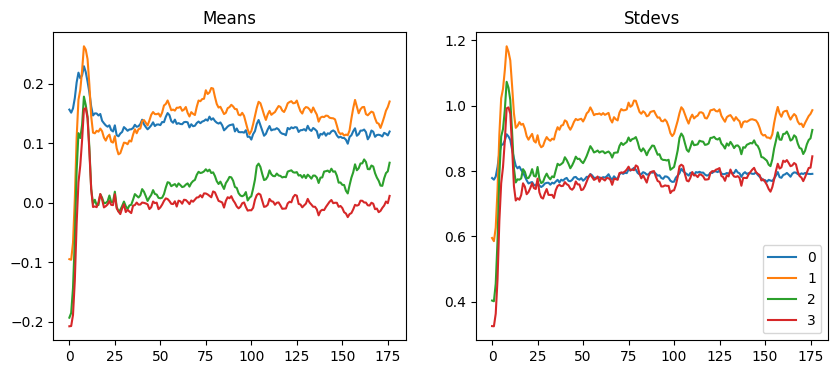

In [71]:
astats.plot_stats()

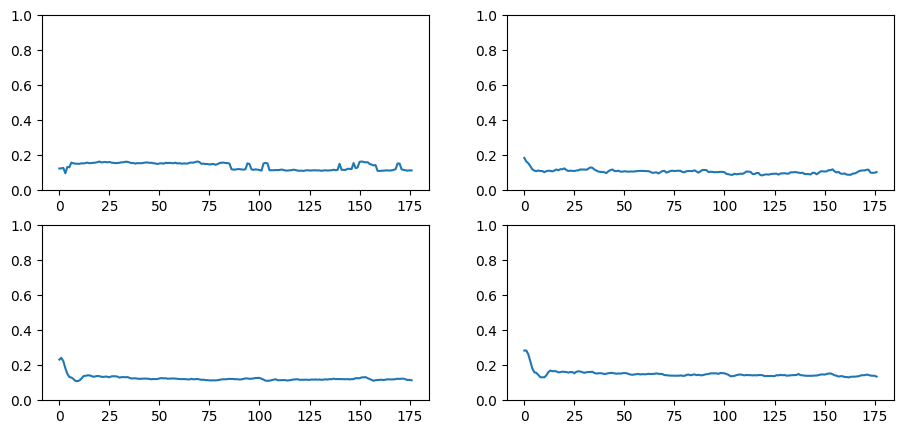

In [72]:
astats.dead_chart()

### LSUV

"All You Need is a Good Init" introduces Layer-wise Sequential Unit-Variance (LSUV).

In [81]:
#export
def _lsuv_stats(hook, mod, inp, outp):
    acts = to_cpu(outp)
    hook.mean = acts.mean()
    hook.std = acts.std()

def lsuv_init(m, m_in, xb):
    h = Hook(m, _lsuv_stats)
    with torch.no_grad():
        while model(xb) is not None and (abs(h.std-1)>1e-3 or abs(h.mean)>1e-3):
            m_in.bias -= h.mean
            m_in.weight.data /= h.std
    h.remove()

In [82]:
model = get_model(act_gr)
relus = [o for o in model.modules() if isinstance(o, GeneralRelu)]
convs = [o for o in model.modules() if isinstance(o, nn.Conv2d)]

In [83]:
for ms in zip(relus, convs): print(ms)

(GeneralRelu(), Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)))
(GeneralRelu(), Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)))
(GeneralRelu(), Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)))
(GeneralRelu(), Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)))


In [84]:
for ms in zip(relus, convs): lsuv_init(*ms, xb.to(def_device))

accuracy,loss,epoch,train
0.771,0.635,0,train
0.833,0.446,0,eval
0.864,0.371,1,train
0.859,0.390,1,eval
0.880,0.327,2,train
0.867,0.372,2,eval


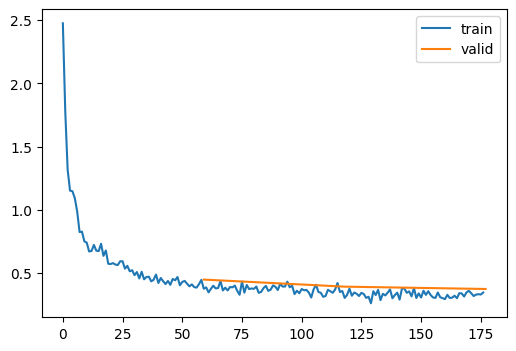

In [85]:
set_seed(42)
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(3)

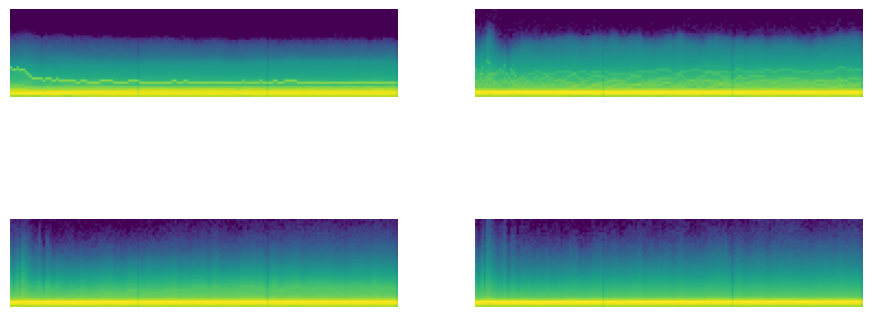

In [86]:
astats.color_dim()

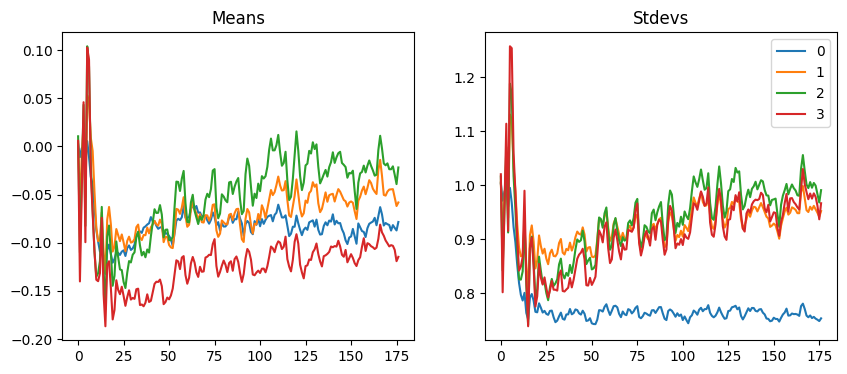

In [87]:
astats.plot_stats()

### Batch Normalization

### Layer Normalization

We will start with layer normalization, a simpler technique.

In [88]:
class LayerNorm(nn.Module):
    def __init__(self, dummy, eps=1e-5):
        super().__init__()
        self.eps = eps
        self.mult = nn.Parameter(tensor(1.))
        self.add = nn.Parameter(tensor(0.))

    def forward(self, x):
        m = x.mean((1,2,3), keepdim=True)
        v = x.var ((1,2,3), keepdim=True)
        x = (x-m) / ((v+self.eps).sqrt())
        return x*self.mult + self.add

In [90]:
#|export
def conv(ni, nf, ks=3, stride=3, act=nn.ReLU, norm=None, bias=True):
    layers = [nn.Conv2d(ni, nf, stride=stride, kernel_size=ks, padding=ks//2, bias=bias)]
    if norm: layers.append(norm(nf))
    if act: layers.append(act())
    return nn.Sequential(*layers)

In [91]:
#|export 
def get_model(act=nn.ReLU, nfs=None, norm=None):
    if nfs is None: nfs = [1,8,16,32,64]
    layers = [conv(nfs[i], nfs[i+1], act=act, norm=norm) for i in range(len(nfs)-1)]
    return nn.Sequential(*layers, conv(nfs[-1], 10, act=None, norm=False, bias=False), nn.Flatten()).to(def_device)

accuracy,loss,epoch,train
0.744,0.715,0,train
0.833,0.455,0,eval
0.853,0.399,1,train
0.852,0.410,1,eval
0.870,0.353,2,train
0.859,0.384,2,eval


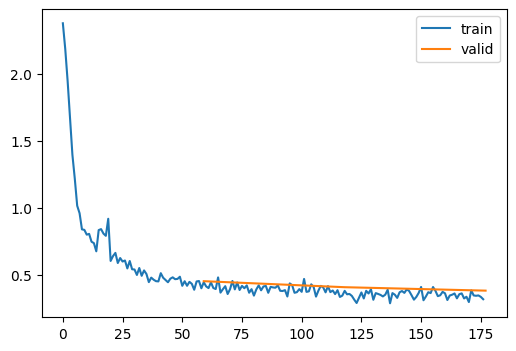

In [92]:
set_seed(42)
model = get_model(act_gr, norm=LayerNorm).apply(iw)
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(3)

### BatchNorm

In [97]:
class BatchNorm(nn.Module):
    def __init__(self, nf, mom=0.1, eps=1e-5):
        super().__init__()
        # NB: pytorch bn mom is opposite of what you'd expect
        self.mom,self.eps = mom,eps
        self.mults = nn.Parameter(torch.ones (nf,1,1))
        self.adds  = nn.Parameter(torch.zeros(nf,1,1))
        self.register_buffer('vars',  torch.ones (1,nf,1,1))
        self.register_buffer('means', torch.zeros(1,nf,1,1))

    def update_stats(self, x):
        m = x.mean((0,2,3), keepdim=True)
        v = x.var ((0,2,3), keepdim=True)
        self.means.lerp_(m, self.mom)
        self.vars.lerp_ (m, self.mom)
        return m,v
    
    def forward(self, x):
        if self.training:
            with torch.no_grad(): m,v = self.update_stats(x)
        else: m,v = self.means,self.vars
        x = (x-m) / (v+self.eps).sqrt()
        return x*self.mults + self.adds

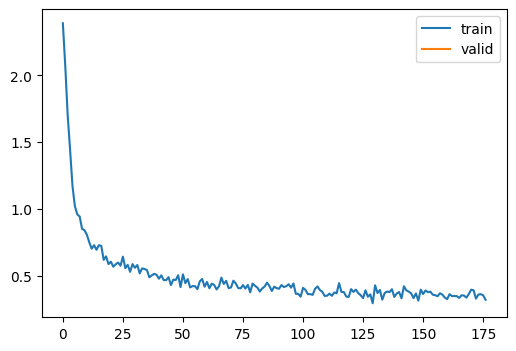

In [98]:
model = get_model(act_gr, norm=BatchNorm).apply(iw)
set_seed(42)
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.4, cbs=cbs)
learn.fit(3)

### Towards 90%...

In [100]:
dls = DataLoaders.from_dd(tds, 256, num_workers=4)

accuracy,loss,epoch,train
0.826,0.483,0,train
0.853,0.391,0,eval
0.872,0.345,1,train
0.867,0.363,1,eval
0.883,0.315,2,train
0.876,0.337,2,eval


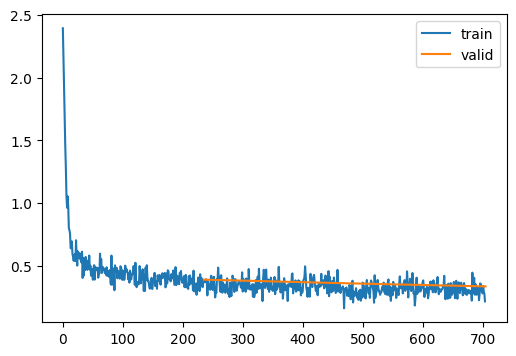

In [101]:
set_seed(42)
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(3)

accuracy,loss,epoch,train
0.900,0.269,0,train
0.888,0.305,0,eval
0.903,0.259,1,train
0.889,0.305,1,eval


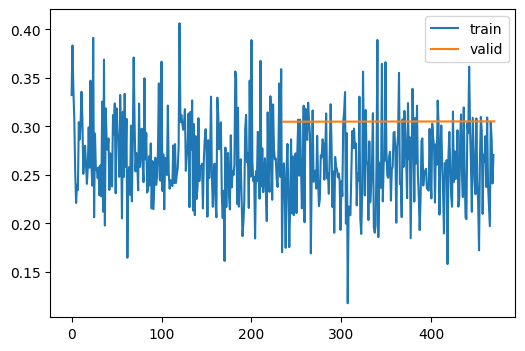

In [102]:
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.05, cbs=cbs)
learn.fit(2)